In [1]:
%run "../../shared/utilz_includez.ipynb"

In [2]:
from skimage import io, img_as_float, img_as_ubyte
from skimage import color , measure

from scipy import ndimage as nd

import cv2 
from skimage.segmentation import clear_border

In [3]:
def plot_image( img_array , plotit=True, title=None, cmapd='gray'):     
    print( f"\n{ '-'*7 } { title if title else type(img_array) } { '-'*7 }" )
    print( f"image.shape = {img_array.shape}" ) 
    print( f"datatype = {img_array.dtype}")
    print( f"min = {np.min(img_array)} , max = {np.max(img_array)}\n" )
    if plotit:
        if cmapd:
            plt.imshow( img_array , cmap=cmapd)
        else:
            plt.imshow( img_array )
    if title:
        plt.title(title)
        
        
        
def fetch_image(imgpath, forceuint8=True):
    img = io.imread( imgpath )
    if forceuint8:
        img = np.uint8(img)
    gimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY ) 
    return img, gimg
    
def grid_plot_images( imgz, titlz=None, plotit=True, nr=1, nc=2):
    nr = np.int( len(imgz) / nc )
    if len(imgz) % 2 != 0:
        nr = nr+1
    for i in range( len(imgz) ):
        plt.subplot(nr, nc, i+1 )
        plot_image( imgz[i], title=titlz[i] if titlz else None , plotit=plotit); 
        

# 1. Grain Analysis on mutliple files using watershed segmentation
- follows from `notebook 007`

In [4]:
## clean, segment using watershed and generate properties
kern = np.ones( (3,3), dtype=np.uint8 )

pixels_to_um = 0.5 

radianz = 57.2958


propz = ['Label', "Area", "Perimeter", 
     "equivalent_diameter", "orientation",
    "MajorAxisLength", "MinorAxisLength",
     "MinIntensity", "MaxIntensity", "MeanIntensity",
    ]
addz = ["Area_nm", "Perimeter_nm", 
     "equivalent_diameter_nm", 
    "orientation_degrees",
    "MajorAxisLength_nm", "MinorAxisLength_nm",]

def clean_prepare_binary( gimg , blursize=3):
    # a. binary threshold 
    otsu, timg = cv2.threshold(gimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # b. erode dilate @ crispier grains
    timg = cv2.erode( timg, kern, iterations=1)
    timg = cv2.dilate( timg, kern, iterations=1)

    # c. median blur pixeletation << should this go first 
    timg = cv2.medianBlur(timg, blursize)
    
    return timg

def watershed_segment(cimg, gimg, thresh_val=0.2, kern=np.ones((3,3), dtype=np.uint8), iterz=1, dilate_iterz=1 ): 
    # a. morphological extra 
    mimg = cv2.morphologyEx( gimg, cv2.MORPH_OPEN, kern, iterations=iterz)
    
    # b. clear border cells/grains at this point 
    mimg = clear_border( mimg )
    
    # c. Identify sure foreground pixels     
    sure_bg = cv2.dilate( mimg, kern, iterations=dilate_iterz) 
    mimg = cv2.distanceTransform( mimg, cv2.DIST_L2, 3)
    
    # d.  Threshold
    _, sure_fg = cv2.threshold(mimg, thresh_val*mimg.max(),  255, 0)
    sure_fg = np.uint8( sure_fg )
    
    # e. gen markers and distinguish unkownz from background 
    _, markerz = cv2.connectedComponents( sure_fg )
    
    unknownz = cv2.subtract( sure_bg, sure_fg)
    markerz = markerz+10
    markerz[ unknownz == 255 ] = 0 
    
    # f. watershed
    watershed = cv2.watershed( cimg, markerz )

    ready_img = cimg.copy()
    ready_img[ markerz == -1] = [0, 255, 255]
    rimg2 = color.label2rgb( markerz, bg_label=0 )
    
    ## return markerz, rgb labeled images
    return markerz, rimg2

def gen_properties(markerz, gimg): 
    clusterz = measure.regionprops(markerz, intensity_image=gimg)
    g = clusterz[0]
    
    ## Create dframe for it
    dd = []
    for g in clusterz:
        gl = []
        for p in propz:
            gl.append( g[p] )

        for ap in addz:
            p = "_".join( ap.split("_")[:-1])

            ## Area_nm
            if( p == 'Area'):
                gl.append( g[p] * pixels_to_um**2 )
            ## Orientation_nm
            elif( p == 'orientation'):
                gl.append( g[p]* radianz ) 
            ## anything that's not Intensity
            else:
                gl.append( g[p]* pixels_to_um ) 


    dd.append( gl )
    
    # df = pd.DataFrame.from_records( dd , columns=propz+addz )
    ## return list oobject 
    return dd



    


------- Orignial Color -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Original Gray -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255



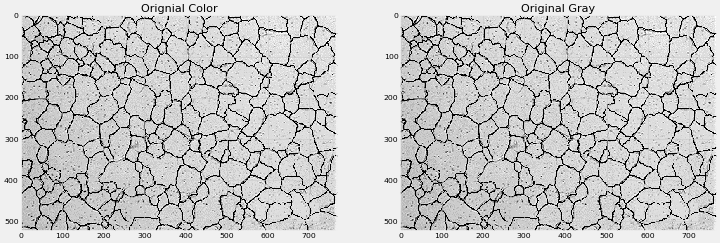

In [5]:
ip = "https://4.bp.blogspot.com/_6sy6DITvP_s/TKbdzLMBH5I/AAAAAAAABmw/1M8z5xwIcno/s1600/505h.JPG"
img, gimg = fetch_image( ip )
grid_plot_images( [img, gimg], ["Orignial Color", "Original Gray"])


------- Grain Image 0 -------
image.shape = (524, 768, 3)
datatype = uint8
min = 0 , max = 255


------- Grain Image 1 -------
image.shape = (201, 251, 3)
datatype = uint8
min = 0 , max = 255


------- Grain Image 2 -------
image.shape = (180, 280, 3)
datatype = uint8
min = 0 , max = 255


------- Grain Image 3 -------
image.shape = (198, 255, 3)
datatype = uint8
min = 0 , max = 255



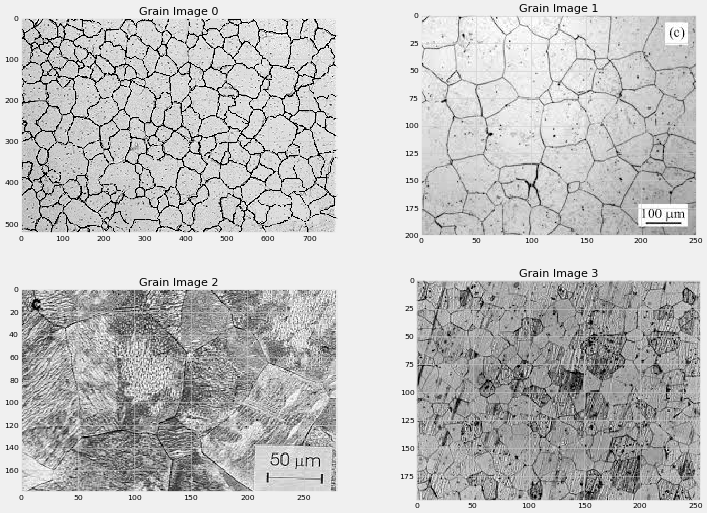

In [6]:
many_imagez = [
    "https://4.bp.blogspot.com/_6sy6DITvP_s/TKbdzLMBH5I/AAAAAAAABmw/1M8z5xwIcno/s1600/505h.JPG",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS0MR_ogy4X74rL4Q5DX6bTybb--rvWbeXaiV7AkWyTcV3CMpkB&usqp=CAU",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTCt_Cp3aKgkzxrBSJzO0lJYNlfR4xfSo_TzJAIHQCjeHlbaWBG&usqp=CAU",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTi79GdDDRQMqyXRoPppO0UZScL4kAioE23tsHW7IWY6_UZbOn-&usqp=CAU",
    
]


origi_and_gray_imagez = {}

for i, ip in enumerate(many_imagez):
    c, g = fetch_image( ip )
    origi_and_gray_imagez[f"Grain Image {i}"] = (c, g )
    

grid_plot_images( [x[0] for x in origi_and_gray_imagez.values() ], list(origi_and_gray_imagez.keys()) )


------- Grain Image 0 -------
image.shape = (524, 768)
datatype = uint8
min = 0 , max = 255


------- Grain Image 1 -------
image.shape = (201, 251)
datatype = uint8
min = 0 , max = 255


------- Grain Image 2 -------
image.shape = (180, 280)
datatype = uint8
min = 0 , max = 255


------- Grain Image 3 -------
image.shape = (198, 255)
datatype = uint8
min = 0 , max = 255



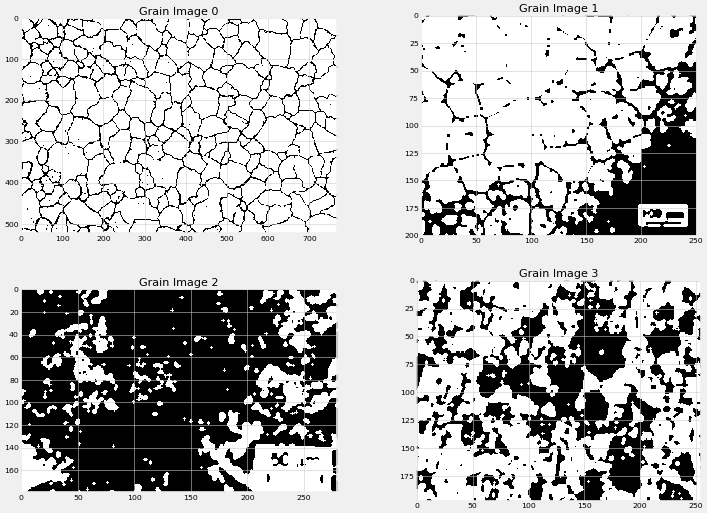

In [7]:
### 1. Clean Imagez
for k, g in origi_and_gray_imagez.items(): # 0 = color, 1 = grayscale 
    o = clean_prepare_binary(g[1])
    origi_and_gray_imagez[k] = [*g, o ]
    
grid_plot_images( [ x[2] for x in origi_and_gray_imagez.values()] , list(origi_and_gray_imagez.keys()) )


------- Grain Image 0 -------
image.shape = (524, 768, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Grain Image 1 -------
image.shape = (201, 251, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Grain Image 2 -------
image.shape = (180, 280, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Grain Image 3 -------
image.shape = (198, 255, 3)
datatype = float64
min = 0.0 , max = 1.0



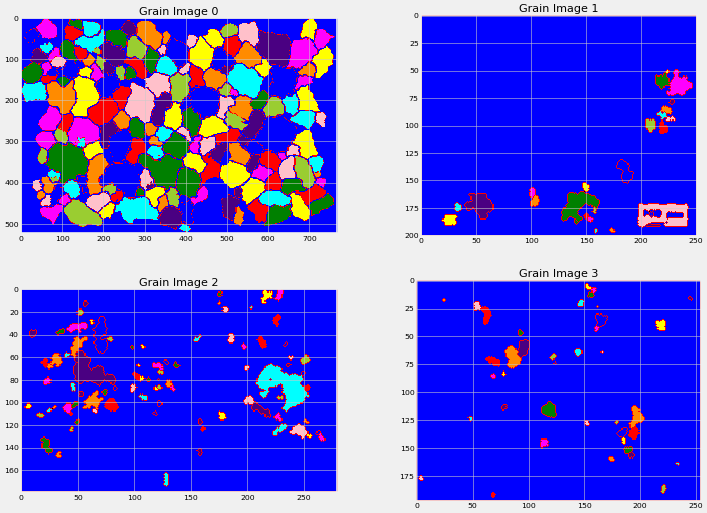

In [8]:
### 2. Watershed segment
for k, g in origi_and_gray_imagez.items(): # 0 = color, 1 = grayscale 
    o, r = watershed_segment(g[0], g[2])
    origi_and_gray_imagez[k] = [*g, (o,r)]
    
grid_plot_images( [ x[3][1] for x in origi_and_gray_imagez.values()] , list(origi_and_gray_imagez.keys()) )


In [9]:
### 3. Generate properties dataframe
df_propz = []
for k, g in origi_and_gray_imagez.items():
    df_propz.append( *gen_properties( g[3][0], g[1]))
#     print( ">>>>", df_propz, "\n\n")
    
grain_analysis_df = pd.DataFrame.from_records( df_propz , columns=propz+addz)

print( grain_analysis_df.shape )

grain_analysis_df.head(3)

(4, 16)


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
0,186,314,75.461941,19.994930,1.216161,25.202625,16.696898,56,255,204.939490,78.50,37.730970,9.997465,69.680925,12.601312,8.348449
1,36,5,5.207107,2.523133,-0.321751,3.098387,1.788854,193,196,194.400000,1.25,2.603553,1.261566,-18.434955,1.549193,0.894427
2,96,38,28.142136,6.955796,-0.001036,12.867970,3.990273,147,241,188.894737,9.50,14.071068,3.477898,-0.059387,6.433985,1.995136


In [10]:
np.round(grain_analysis_df.describe() , 1)

,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
count,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
mean,91.8,91.0,28.9,8.1,0.2,11.0,6.3,133.8,221.5,188.7,22.8,14.5,4.1,12.8,5.5,3.2
std,67.9,149.4,32.7,8.2,0.7,10.5,7.0,57.0,31.1,16.2,37.4,16.4,4.1,38.9,5.3,3.5
min,36.0,5.0,5.2,2.5,-0.3,3.0,1.8,56.0,194.0,166.6,1.2,2.6,1.3,-18.4,1.5,0.9
25%,45.8,6.5,6.4,2.9,-0.1,3.1,2.5,118.2,195.5,183.3,1.6,3.2,1.4,-4.7,1.5,1.3
50%,72.5,22.5,17.5,5.0,-0.0,8.0,3.4,143.0,218.5,191.6,5.6,8.7,2.5,-0.0,4.0,1.7
75%,118.5,107.0,40.0,10.2,0.3,16.0,7.2,158.5,244.5,197.0,26.8,20.0,5.1,17.4,8.0,3.6
max,186.0,314.0,75.5,20.0,1.2,25.2,16.7,193.0,255.0,204.9,78.5,37.7,10.0,69.7,12.6,8.3


# 2. Cell Nuclei Analysis using Watershed Segmentation


------- Cell # 0 -------
image.shape = (504, 700, 3)
datatype = uint8
min = 0 , max = 255


------- Cell # 1 -------
image.shape = (368, 508, 3)
datatype = uint8
min = 0 , max = 255


------- Cell # 2 -------
image.shape = (900, 1200, 3)
datatype = uint8
min = 0 , max = 255


------- Cell # 3 -------
image.shape = (194, 259, 3)
datatype = uint8
min = 0 , max = 255


------- Cell # 4 -------
image.shape = (504, 700, 3)
datatype = uint8
min = 0 , max = 255


------- Cell # 5 -------
image.shape = (368, 508, 3)
datatype = uint8
min = 0 , max = 255



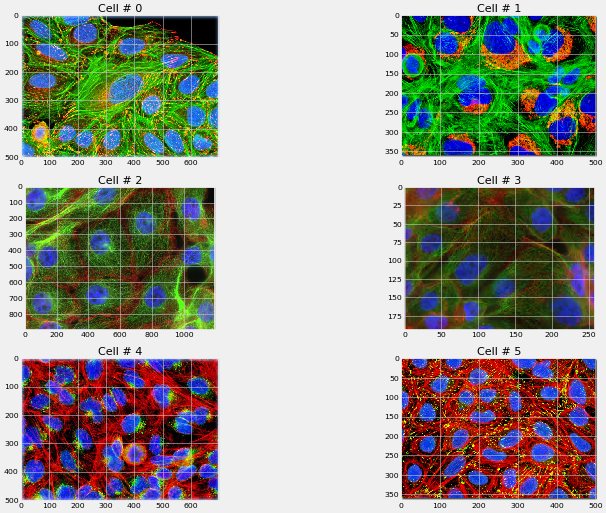

In [159]:
# pathz_cell_imagez = [
#     "https://blog.dana-farber.org/insight/wp-content/uploads/2018/06/nci-vol-9896-72-1.jpg",
#     "https://media.sciencephoto.com/c0/28/78/30/c0287830-800px-wm.jpg",
#     "https://media.sciencephoto.com/image/c0290560/800wm",
#     "https://media.sciencephoto.com/image/c0287829/800wm", 
#     "https://media.sciencephoto.com/image/c0287831/800wm"
    
# ]

pathz_cell_imagez = [
    "https://static5.olympus-lifescience.com/modules/imageresizer/2ed/31f/ae154f0fef/700x504p350x252.jpg",
    "https://micro.magnet.fsu.edu/primer/techniques/fluorescence/gallery/cells/u2/images/u2large.jpg",
    "https://cdn8.dissolve.com/p/D943_211_356/D943_211_356_1200.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQQITWNAK8ICAG5V_GZ5wPlkGomWQlbMM3viB-wMkuOwJ__QDGe&usqp=CAU",
    "https://static4.olympus-lifescience.com/modules/imageresizer/728/360/2c5cd27ed8/700x504p350x252.jpg",
    "https://micro.magnet.fsu.edu/primer/techniques/fluorescence/gallery/cells/u2/images/u2large14.jpg",
    
]

dict_cell_imagez = {}

for i, ip in enumerate(pathz_cell_imagez):
    c, g = fetch_image( ip )
    dict_cell_imagez[f"Cell # {i}"] = (c, g )
    

grid_plot_images( [x[0] for x in dict_cell_imagez.values() ], list(dict_cell_imagez.keys()) )

# print("\n===== GRAYZ =====")
# grid_plot_images( [x[0] for x in dict_cell_imagez.values() ], list(dict_cell_imagez.keys()), plotit=False )

## 2.1. Steps to use

First try with one image and check the output on each page to ensure sensitivity to context like if dilation may over reduce size of cells etc 

1. Select the color channel with the cell nuclei. E.G. blue color 
2. Clean resulting image
3. Run watershed segmentation 
4. Generate properties 


In [160]:
blue_channel = 2

def nuclei_channel_only(img):
    return img[:, :, blue_channel]


------- Colored -------
image.shape = (368, 508, 3)
datatype = uint8
min = 0 , max = 255


------- Grayscale -------
image.shape = (368, 508)
datatype = uint8
min = 0 , max = 255


------- Blue Channel only -------
image.shape = (368, 508)
datatype = uint8
min = 0 , max = 255



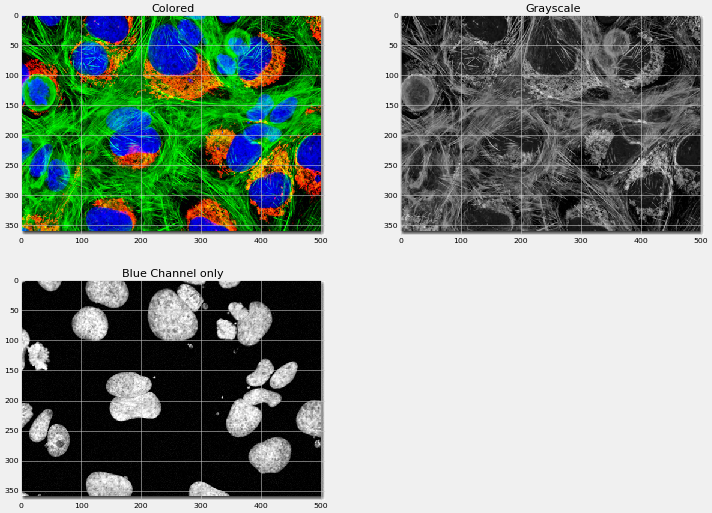

In [161]:
## 1. Testing select blue channel only as nuclei 
img, gimg = list(dict_cell_imagez.values())[1]
cimg = nuclei_channel_only( img )
grid_plot_images([img, gimg, cimg], ["Colored", "Grayscale", "Blue Channel only"])


------- Cell # 0 -------
image.shape = (504, 700)
datatype = uint8
min = 0 , max = 255


------- Cell # 1 -------
image.shape = (368, 508)
datatype = uint8
min = 0 , max = 255


------- Cell # 2 -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Cell # 3 -------
image.shape = (194, 259)
datatype = uint8
min = 0 , max = 255


------- Cell # 4 -------
image.shape = (504, 700)
datatype = uint8
min = 0 , max = 255


------- Cell # 5 -------
image.shape = (368, 508)
datatype = uint8
min = 0 , max = 255



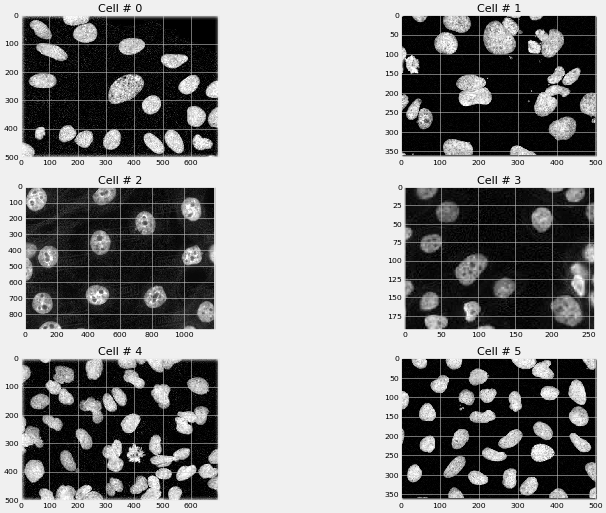

In [162]:
## 2. Now do for all cells in dict 
for k, g in dict_cell_imagez.items():
    dict_cell_imagez[k] = [*g, nuclei_channel_only(g[0])]
    
grid_plot_images( [x[2] for x in dict_cell_imagez.values() ], list(dict_cell_imagez.keys()) )


------- Cell # 0 -------
image.shape = (504, 700, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Cell # 1 -------
image.shape = (368, 508, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Cell # 2 -------
image.shape = (900, 1200, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Cell # 3 -------
image.shape = (194, 259, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Cell # 4 -------
image.shape = (504, 700, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Cell # 5 -------
image.shape = (368, 508, 3)
datatype = float64
min = 0.0 , max = 1.0



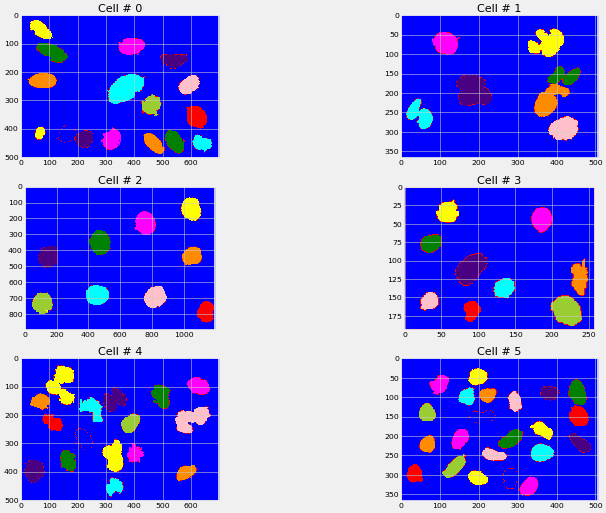

In [163]:
### 1. Clean Imagez
for k, g in dict_cell_imagez.items(): # 0 = color, 1 = grayscale , 2 = blue_channel_nuclei_only
    o = clean_prepare_binary(g[2], blursize=9)
    dict_cell_imagez[k] = [*g, o ]
    
### 2. Watershed segment
for k, g in dict_cell_imagez.items(): # 0 = color, 1 = grayscale , 2 = blue_channel_nuclei_only
    o, r = watershed_segment(g[0], g[3], dilate_iterz=10, thresh_val=0.23, iterz=1)
    dict_cell_imagez[k] = [*g, (o,r)]
    
grid_plot_images( [ x[4][1] for x in dict_cell_imagez.values()] , list(dict_cell_imagez.keys()) )


In [164]:
### 3. Generate properties dataframe
df_propz = []
for k, g in dict_cell_imagez.items():
    df_propz.append( *gen_properties( g[4][0], g[2]))
#     print( ">>>>", df_propz, "\n\n")
    
cell_analysis_df = pd.DataFrame.from_records( df_propz , columns=propz+addz)

print( grain_analysis_df.shape )
cell_analysis_df.head(3)

(4, 16)


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
0,26,2750,250.663997,59.172703,1.234393,71.893416,50.489954,0,255,200.617818,687.50,125.331998,29.586351,70.725508,35.946708,25.244977
1,17,3491,262.285317,66.669928,-1.301430,76.878376,58.355780,0,255,157.918075,872.75,131.142659,33.334964,-74.566484,38.439188,29.177890
2,21,134,55.662951,13.061933,1.111416,19.469705,10.180959,117,170,142.119403,33.50,27.831475,6.530967,63.679479,9.734852,5.090479


In [165]:
np.round(cell_analysis_df.describe(), 1 )


,Label,Area,Perimeter,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,MinIntensity,MaxIntensity,MeanIntensity,Area_nm,Perimeter_nm,equivalent_diameter_nm,orientation_degrees,MajorAxisLength_nm,MinorAxisLength_nm
count,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
mean,23.5,1839.7,179.8,44.2,-0.1,52.4,38.9,34.0,240.8,172.7,459.9,89.9,22.1,-7.4,26.2,19.4
std,5.5,1354.9,95.0,21.7,1.1,24.0,19.9,53.5,34.7,22.6,338.7,47.5,10.8,61.7,12.0,9.9
min,17.0,134.0,55.7,13.1,-1.3,19.5,10.2,0.0,170.0,142.1,33.5,27.8,6.5,-74.6,9.7,5.1
25%,19.5,712.0,100.2,28.4,-0.9,33.7,24.6,0.0,255.0,159.2,178.0,50.1,14.2,-51.0,16.9,12.3
50%,23.5,2130.5,208.4,51.7,-0.4,59.7,44.7,0.0,255.0,170.3,532.6,104.2,25.9,-24.9,29.8,22.3
75%,26.0,2717.2,259.4,58.8,0.8,70.2,54.2,65.2,255.0,190.7,679.3,129.7,29.4,45.6,35.1,27.1
max,32.0,3491.0,265.7,66.7,1.2,76.9,58.4,117.0,255.0,200.6,872.8,132.8,33.3,70.7,38.4,29.2


In [18]:
## 4. More clean up - Can remove outliers b/c of overlapping cells for example and any remaining noise????
# E.G. filter at diameter above 75th or something 